# From cosmology to linear power parameters

Given a cosmological model, show that we can describe its linear power spectrum, in velocity units, using only a handful of parameters.

### Notation

We will use $P(z,k)$ to refer to the linear power spectrum at redshift $z$, wavenumber $k$, in comoving units (Mpc).

We will use the superscript $^0$ to refer to the fiducial cosmological model (Planck 2018 + BAO or similar).

We will use the subscript $_\star$ to refer to quantities evaluated at redshift $z_\star=3$.

Following this logic, $P_\star^0(k) = P^0(z_\star,k)$ is the linear spectrum for the fiducial cosmology, at $z_\star$.

### Velocity units

The 1D flux power spectrum is measured in velocity units (or in redshift differences), and in order to avoid an unnecessary dependency on the Hubble parameter we will parameterize our linear power spectrum in velocity units as well. 

We use $q$, instead of $k$, to refer to wavenumbers expressed in velocity units. 
Similarly, we use $Q$ instead of $P$ to refer to power spectra measured in velocity units.

The relation between both units is given by $A(z)=H(z)/(1+z)$. 
Therefore, the relation between both power spectra is:
$$ Q(z,q) = A^3(z) \, P (z,k=A(z) q )$$

### Linear growth

Ignoring the effect of neutrinos (see below), the linear power spectrum scales with redshfit following:
$$ P(z,k) = \left( \frac{D(z)}{D_\star} \right)^2 P_\star(k) $$
where $D(z)$ is the linear growth factor. Neutrinos add a scale dependency, but for low neutrino masses (the only ones allowed by cosmological observations) and small simulation boxes, the linear growth can be assumed to be scale independent. We will test this approximation later.

The linear growth is _not_ scale independent when using velocity units, but we can compute the following relation:

\begin{align}
Q(z,q) &= A^3(z) \, P (z,k=A(z) q )  \\
    &= A^3(z) \left( \frac{D(z)}{D_\star} \right)^2 P_\star(k=A(z) q )  \\
    &= \left( \frac{A(z)}{A_\star} \right)^3 \left( \frac{D(z)}{D_\star} \right)^2 
        Q_\star \left( q^\prime=\frac{A(z)}{A_\star} q \right)     
\end{align}

### Shape fitting

We will describe the amplitude and shape of the linear power, at $z_\star$, with a handful of parameters.

In practice, we will describe the ratio of the linear power with respect to that of the fiducial cosmology:

$$ B(q) = \frac{Q_\star(q)}{Q^0_\star(q)} $$

We will fit a 2nd order polynomial to the logarithm of the ratio of power spectra, around $q_p=0.009$ s/km.

$$ \log B(q) \approx \log B_p + n_p \log \left( \frac{q}{q_p}\right) + \alpha_p \log^2 \left( \frac{q}{q_p}\right)$$  

### Putting everything together

Using the discussion above, we can now describe the power spectrum in any cosmology using the fiducal cosmology, and a handful of functions $A(z)$ and $D(z)$. 

\begin{align}
  Q(z,q) &= A^3(z) \, P (z,k=A(z) q )  \\
  &= A^3(z) \left( \frac{D(z)}{D_\star} \right)^2 P_\star(k=A(z) q )  \\
  &= \left( \frac{A(z)}{A_\star} \right)^3 \left( \frac{D(z)}{D_\star} \right)^2 
        Q_\star \left( q^\prime=\frac{A(z)}{A_\star} q \right)  \\
  &= \left( \frac{A(z)}{A_\star} \right)^3 \left( \frac{D(z)}{D_\star} \right)^2 
        B\left( q^\prime=\frac{A(z)}{A_\star} q \right) \, 
        Q^0_\star \left( q^\prime=\frac{A(z)}{A_\star} q \right)  \\
  &= \left( A_\star^0 \frac{A(z)}{A_\star} \right)^3 \left( \frac{D(z)}{D_\star} \right)^2 
        B\left( q^\prime=\frac{A(z)}{A_\star} q \right) \,
        P^0_\star \left( k = A_\star^0 \frac{A(z)}{A_\star} q \right)  \\
  &= \left( A_\star^0 \frac{A(z)}{A_\star} \right)^3 
        \left( \frac{D(z)}{D_\star} \frac{D^0_\star}{D^0(z)} \right)^2 
        B\left( q^\prime=\frac{A(z)}{A_\star} q \right) \,
        P^0 \left( z, k = A_\star^0 \frac{A(z)}{A_\star} q \right)  \\
  &= \left( \frac{A_\star^0}{A^0(z)} \frac{A(z)}{A_\star} \right)^3 
        \left( \frac{D(z)}{D_\star} \frac{D^0_\star}{D^0(z)} \right)^2 
        B\left( q^\prime=\frac{A(z)}{A_\star} q \right) \,
        Q^0 \left( z, q^\prime = \frac{A_\star^0}{A^0(z)} \frac{A(z)}{A_\star} q \right)  \\
\end{align}

If it was not for the fact that the BAO wiggles are shifted in the different cosmologies, the equation above would be exact.

### Approximating the linear growth and the deceleration with one parameter each

In  Eistein - de Sitter universe, both $A(z)$ and $D(z)$ would be cosmology independent:
$$\frac{A(z)}{A_\star} = \sqrt{ \frac{1+z}{1+z_\star} }$$
and 
$$\frac{D(z)}{D_\star} = \frac{1+z_\star}{1+z}$$

At high redshift, $z>2$, most models allowed by current observations are quite similar to EdS. We will describe the deviations from EdS using a Taylor expansion around $z_\star=3$.

$$ \frac{A(z)}{A_\star} = 1 + \frac{\Delta z}{1+z_\star} 
    \left[ \frac{1}{A_\star} \frac{\partial H}{\partial z} \Bigr \rvert_{z_\star} - 1 \right] 
    = 1 + \frac{\Delta z}{1+z_\star} 
    \left[ \frac{3}{2} g_\star - 1 \right] $$
where we have defined
$$ g(z) = \frac{\partial \log H(z)}{\partial \log (1+z)^{3/2}} 
    = \frac{2}{3} \frac{1}{A(z)} \frac{\partial H}{\partial z}$$


Similarly, we have:

$$ \frac{D(z)}{D_\star} = 1 + \frac{\Delta z}{D_\star} \frac{\partial D}{\partial z} \Bigr \rvert_{z_\star} 
    = 1 - \frac{\Delta z}{1+z_\star} f_\star $$
where we have used
$$ f(z) = \frac{\partial \log D(z)}{\partial \log a(z)} = - \frac{1+z}{D(z)} \frac{\partial D}{\partial z}$$

### Summary

We can describe the linear power spectrum with five parameters:
 - three for $B(z)$: the shape of the ratio around ($z_\star,k_p$)
 - $f_\star$:  the logarithmic growth rate at $z_\star$
 - $g_\star$: the logarithmic expansion rate at $z_\star$

In [1]:
%matplotlib inline
import numpy as np
import os
import copy
## Set default plot size, as normally its a bit too small
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import camb
from camb import model, initialpower
import fit_pk
import read_genic

In [2]:
def plot_reconstructed_power(cosmo,cosmo_fid,two_params_only):
    z_star=3.0
    kp_kms=0.009
    # get 5 parameters for input cosmology
    linP_params=fit_pk.parameterize_cosmology(cosmo,z_star=z_star,kp_kms=kp_kms)
    print('input cosmology',linP_params)
    # get 5 parameters for fiducial cosmology
    linP_params_fid=fit_pk.parameterize_cosmology(cosmo_fid,z_star=z_star,kp_kms=kp_kms)
    print('fiducial cosmology',linP_params_fid)
    if two_params_only:
        # make copy of input parameters, and reset 3 of them to fiducial values
        linP_params_2p=copy.deepcopy(linP_params)
        linP_params_2p['f_star']=linP_params_fid['f_star']
        linP_params_2p['g_star']=linP_params_fid['g_star']
        linP_params_2p['linP_kms'][2]=linP_params_fid['linP_kms'][2]
        print('input cosmology 2p',linP_params_2p)
    # compute first linear power spectra, in velocity units
    # output redshifts
    zs=[2,3,4,5]
    Nz=len(zs)
    # these are the power spectra that we would like to recover
    k_kms, zs_out, P_kms = fit_pk.get_linP_kms(cosmo,zs)
    # reconstruct 
    k=np.logspace(-5,-1,200)
    recP_kms=fit_pk.reconstruct_linP_kms(zs,k,cosmo_fid,linP_params,z_star=z_star,kp_kms=kp_kms)
    if two_params_only:
        recP_kms_2p=fit_pk.reconstruct_linP_kms(zs,k,cosmo_fid,linP_params_2p,z_star=z_star,kp_kms=kp_kms)

    # make plot
    plt.figure()
    for iz in range(Nz): 
        z=zs_out[iz]
        col = mpl.cm.gist_rainbow(iz/Nz)
        P_true=np.interp(k,k_kms[iz],P_kms[iz])
        #P_rec=recP_kms[iz]
        #P_rec_2p=linP_kms_rel[iz]
        if iz is 0 and two_params_only:
            plt.semilogx(k,recP_kms[iz]/P_true,'-',color='black',label='5 params')
            plt.semilogx(k,recP_kms_2p[iz]/P_true,':',color='black',label='2 params')
        plt.semilogx(k,recP_kms[iz]/P_true,'-',color=col,label='z='+str(z))
        if two_params_only:
            plt.semilogx(k,recP_kms_2p[iz]/P_true,':',color=col)
    plt.semilogx(k,np.ones_like(k),'--',color='gray')
    plt.title(r"Reconstructued CDM+baryon linear power")
    plt.xlabel("k [s/km]")
    plt.ylabel(r"$P_{\rm approx}(k) / P_{\rm true}(k)$")
    plt.legend()
    plt.axhspan(0.97,1.03,alpha=0.1, color='gray')
    plt.axhspan(0.99,1.01,alpha=0.3, color='gray')
    plt.axvspan(0.001,0.05,alpha=0.1, color='gray')
    plt.axvspan(0.009*0.6,0.009/0.6,alpha=0.3, color='gray')

### Specify cosmological models

In [5]:
# setup cosmology
pars = fit_pk.get_cosmology(mnu=0.3,H0=73.0,ns=0.97) #,omk=0.02)
fit_pk.print_info(pars)
# setup fiducial cosmology
pars_fid = fit_pk.get_cosmology()
fit_pk.print_info(pars_fid)

H0 = 73.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.00322 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.97
H0 = 67.0 ; Omega_b h^2 = 0.022 ; Omega_c h^2 = 0.12 ; Omega_k = 0.0 ; ommnuh2 = 0.00064 ; T_CMB = 2.7255 ; A_s = 2.1e-09 ; n_s = 0.96


input cosmology {'f_star': 0.96438412086328507, 'g_star': 0.9603164285445334, 'linP_kms': poly1d([ -0.10677226,  -2.30017839,  15.99859758])}
fiducial cosmology {'f_star': 0.978920353934287, 'g_star': 0.9679033230853668, 'linP_kms': poly1d([ -0.10764506,  -2.30704811,  16.06506849])}
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


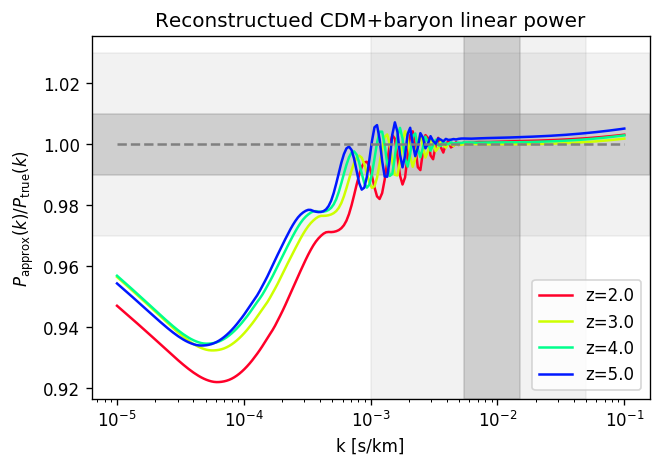

In [6]:
two_params_only=False
plot_reconstructed_power(pars,pars_fid,two_params_only)